# <color style="color:green">**!! Introduction !!**</color>
This exercise serves as a comprehensive guide on the following topics:
* How to convert a Keras model to a TensorFlow Lite model
* How to deploy a TensorFlow Lite model on an MCU and run inference
* How to optimize a TensorFlow Lite model for size and latency

# Setup
Firstly, we load all the necessary packages used in this notebook and define some settings for visualizing the input image data.

In [1]:
# Copyright 2021 ETH Zurich and University of Bologna.
# Licensed under the Apache License, Version 2.0, see https://www.apache.org/licenses/LICENSE-2.0 for details.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import os
import logging

import pandas as pd
import seaborn as sns
import pathlib

# set global seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting parameters for plotting
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

logging.getLogger("tensorflow").setLevel(logging.DEBUG)

print("TensorFlow version: ", tf.__version__)

2025-02-10 19:07:44.264970: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 19:07:44.273518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739210864.281960 4148270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739210864.284401 4148270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 19:07:44.294649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version:  2.18.0


In [2]:
# check if GPU is available
print("GPU is", "AVAILABLE" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


W0000 00:00:1739210865.407698 4148270 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Task 1

### Download the dataset
For this we use the keras.datasets.mnist package. This package contains the Fashion-MNIST dataset which is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [3]:
# Load Fashion-Mnist dataset, we can use Tensorflow for this
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# we save the pixels before normalization for plotting
train_images_float = train_images.astype(np.float32)
test_images_float = test_images.astype(np.float32)

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

print("Shape of train dataset: {}".format(train_images.shape))
print("Shape of train labels: {}".format(train_labels.shape))
print("Shape of test dataset: {}".format(test_images.shape))
print("Shape of test labels: {}".format(test_labels.shape))

Shape of train dataset: (60000, 28, 28)
Shape of train labels: (60000,)
Shape of test dataset: (10000, 28, 28)
Shape of test labels: (10000,)


### Visualize the data
We can visualize the data by plotting 5 samples of each class. We can see that the images are in grayscale format. 

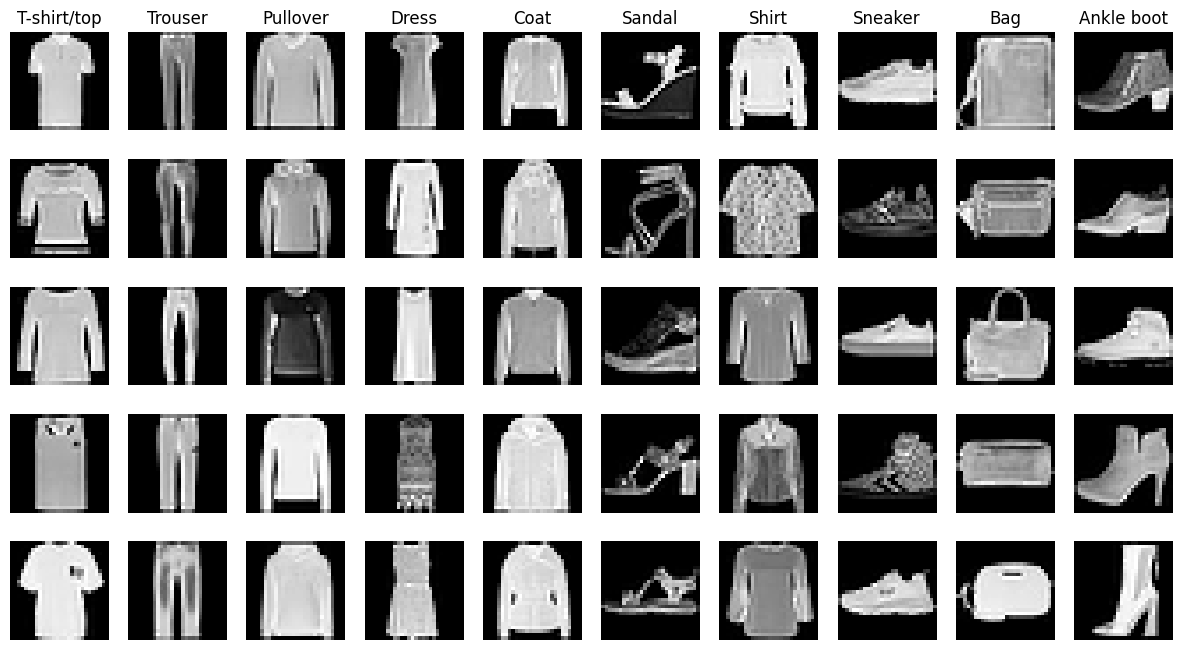

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_images_float[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

### Create the Keras model
The input data is in the range of [0, 255]. We need to rescale the input data to the range of [0, 1] before feeding it to the model because the model should train on normalized and standardized data. We can do this by dividing the input data by 255. Thus, we ensure that all features are in the same range. We create a simple Keras model with one convolutional layers and a dense layer. The model is compiled with the Adam optimizer and the categorical cross-entropy loss function.

In [5]:
# Define the model architecture
fp_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

/home/mgiordano/.pyenv/versions/3.10.9/envs/arm_ws/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [6]:
# Compile the model
fp_model.compile(optimizer='adam',
                # the loss function is the sparse categorical cross-entropy
                # loss. It is used when there are two or more label classes. 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [7]:
# View the model summary
fp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,410 (79.73 KB)

 Trainable params: 20,410 (79.73 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model (this will take a while)
# The early stopping (es) callback will stop the training when the validation loss stops improving
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = fp_model.fit(
    train_images,
    train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[es]
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step - accuracy: 0.7797 - loss: 0.6520 - val_accuracy: 0.8735 - val_loss: 0.3639
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 924us/step - accuracy: 0.8828 - loss: 0.3370 - val_accuracy: 0.8830 - val_loss: 0.3316
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.8938 - loss: 0.3005 - val_accuracy: 0.8883 - val_loss: 0.3186
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 922us/step - accuracy: 0.9015 - loss: 0.2805 - val_accuracy: 0.8903 - val_loss: 0.3095
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 917us/step - accuracy: 0.9057 - loss: 0.2663 - val_accuracy: 0.8928 - val_loss: 0.3019
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.9099 - loss: 0.2547 - val_accuracy: 0.8946 - val_loss: 0.2970
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.9135 - loss: 0.2447 - val_accuracy: 0.8975 - val_loss: 0.2934
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.9166 -

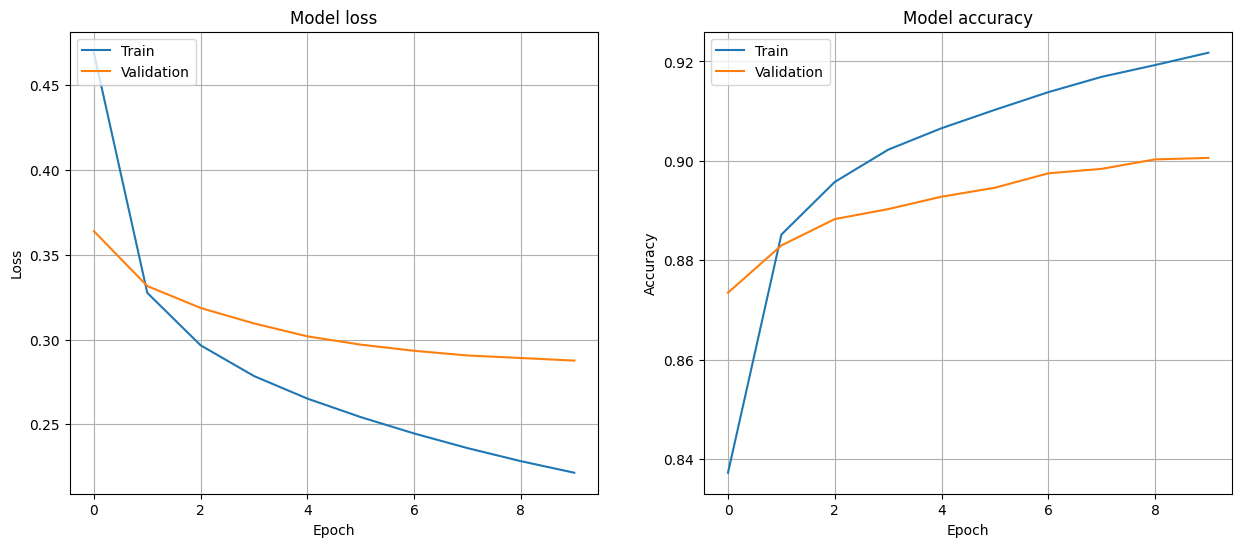

In [9]:
# Plot the training history (loss and accuracy)
# with two subplots
fig, axs = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)

# create the first subplot for the loss
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()

# create the second subplot for the accuracy
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()

In [10]:
# save the model so we can use it later
# without having to retrain it

if not os.path.exists('models'):
    os.makedirs('models')
fp_model.save('models/fmnist_model_f32.h5')

In [11]:
# Evaluate the model on the test set
fp_model = keras.models.load_model('models/fmnist_model_f32.h5')
fp_test_loss, fp_test_acc = fp_model.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', fp_test_acc)
print('Test loss:', fp_test_loss)

313/313 - 0s - 730us/step - accuracy: 0.9006 - loss: 0.2876
Test accuracy: 0.900600016117096
Test loss: 0.28756290674209595


# Evaluate the accuracy via a confusion matrix
We can evaluate the accuracy of the model by plotting a confusion matrix. The confusion matrix shows the ratio of correct and incorrect predictions for each class.

In [12]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
Confusion matrix, without normalization


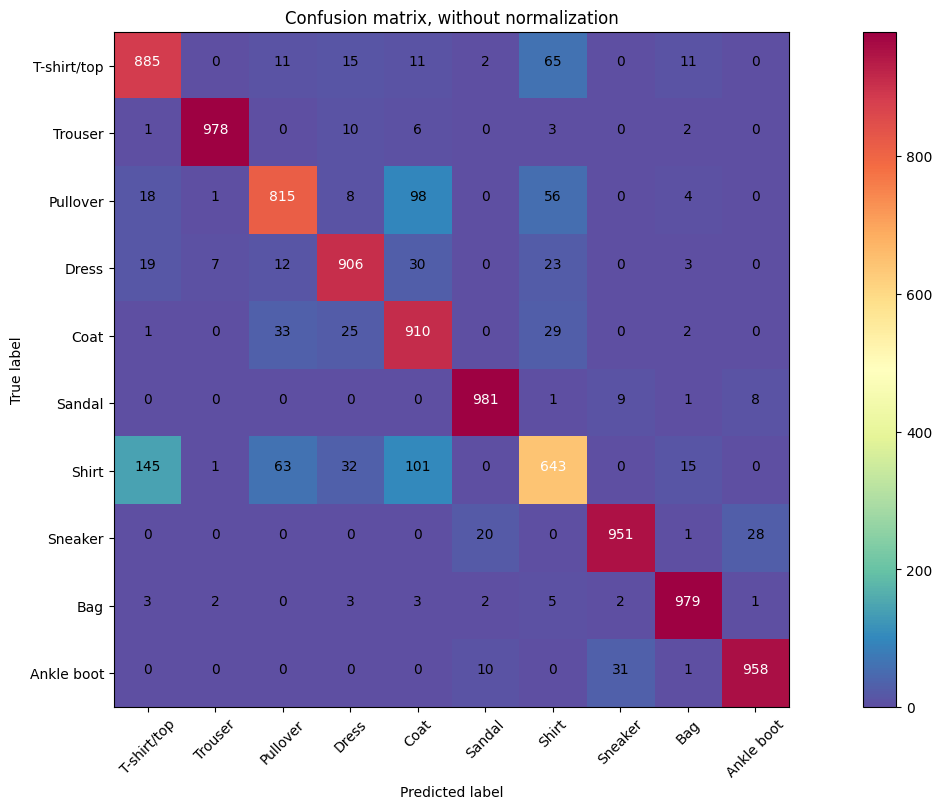

In [13]:
cm = confusion_matrix(test_labels, np.argmax(fp_model.predict(test_images), axis=-1));
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

# Convert the keras model to a tflite model
We can convert the keras model to a tflite model by using the `tf.lite.TFLiteConverter.from_keras_model_file()` function. After converting the model, we can save it to a file. Furthermore, we compare the size of the keras model and the tflite model. The difference is due to the fact that we have a lot of metadata in the keras model which is not present in the tflite model, such as the model architecture, optimizer, loss function, etc. This is also why you cannot call the `model.summary()` function on the tflite model.

`tflite` models can be loaded using the following code:
```python
interpreter = tf.lite.Interpreter(model_path='models/<model_name>.tflite')
interpreter.allocate_tensors()
```

In [14]:
# Convert the model to TFLite without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
fp_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_f32.tflite", "wb").write(fp_tflite_model)

# Show the model size for the non-quantized HDF5 model
fp_h5_in_kb = os.path.getsize('models/fmnist_model_f32.h5') / 1024
print("HDF5 Model size without quantization: %d KB" % fp_h5_in_kb)

# Show the model size for the non-quantized TFLite model
fp_tflite_in_kb = os.path.getsize('models/fmnist_model_f32.tflite') / 1024
print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in file size by a factor of %f" % (fp_h5_in_kb / fp_tflite_in_kb))

INFO:tensorflow:Assets written to: /tmp/tmpk8exkuxj/assets


INFO:tensorflow:Assets written to: /tmp/tmpk8exkuxj/assets


Saved artifact at '/tmp/tmpk8exkuxj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  123770233025312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770233026016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770232706624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770232707328: TensorSpec(shape=(), dtype=tf.resource, name=None)
HDF5 Model size without quantization: 267 KB
TFLite Model size without quantization: 82 KB

Reduction in file size by a factor of 3.238154


W0000 00:00:1739210884.919757 4148270 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739210884.919769 4148270 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-10 19:08:04.919915: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpk8exkuxj
2025-02-10 19:08:04.920116: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-10 19:08:04.920121: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpk8exkuxj
I0000 00:00:1739210884.921755 4148270 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-10 19:08:04.922004: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-10 19:08:04.931872: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpk8exkuxj
2025-02-10 19:08:04.934775: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

# Task 2

### Quantize with dynamic range optimization
We convert the Keras model to an float32 tflite model with dynamic range optimization. Dynamic range quantization is a technique that uses the full range of the data type to represent the weights and activations. This is done by calculating the range of the weights and activations and then scaling them to the full range of the data type. This is done by using the `tf.lite.Optimize.DEFAULT` flag which enables quantization of all fixed parameters. However, this only quantizes static parameters such as weights and biases. The input and output tensors are not quantized. 

In [15]:
# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynR_quant_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_quant8_dynR.tflite", "wb").write(dynR_quant_tflite_model)


print("Model was saved at location: %s" % os.path.abspath('models/fmnist_model_quant8_dynR.tflite'))

INFO:tensorflow:Assets written to: /tmp/tmpsxy8psgs/assets


INFO:tensorflow:Assets written to: /tmp/tmpsxy8psgs/assets


Saved artifact at '/tmp/tmpsxy8psgs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  123770233025312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770233026016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770232706624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770232707328: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model was saved at location: /home/mgiordano/Documents/arm_workshop/jupyter/models/fmnist_model_quant8_dynR.tflite


W0000 00:00:1739210885.049271 4148270 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739210885.049282 4148270 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-10 19:08:05.049365: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsxy8psgs
2025-02-10 19:08:05.049621: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-10 19:08:05.049626: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpsxy8psgs
2025-02-10 19:08:05.051292: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-10 19:08:05.060123: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpsxy8psgs
2025-02-10 19:08:05.063078: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 13715 microseconds.


In [16]:
interpreter = tf.lite.Interpreter(model_content=dynR_quant_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


### Quantize the model to 8-bit integer precision
We can also quantize the model to **full** 8-bit integer precision. This will reduce the model size and improve the inference speed. To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a `RepresentativeDataset`. This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.

In [17]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpj9nlrckp/assets


INFO:tensorflow:Assets written to: /tmp/tmpj9nlrckp/assets


Saved artifact at '/tmp/tmpj9nlrckp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  123770233025312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770233026016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770232706624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123770232707328: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/mgiordano/.pyenv/versions/3.10.9/envs/arm_ws/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1739210885.190608 4148270 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739210885.190616 4148270 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-10 19:08:05.190703: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj9nlrckp
2025-02-10 19:08:05.190889: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-10 19:08:05.190893: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpj9nlrckp
2025-02-10 19:08:05.192340: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-10 19:08:05.201241: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedMod

In [18]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [19]:
# Save the quantized model to disk
open("models/fmnist_full_quant.tflite", "wb").write(tflite_model_quant_int8)

print("Model was saved at location: %s" % os.path.abspath('models/fmnist_full_quant.tflite'))

Model was saved at location: /home/mgiordano/Documents/arm_workshop/jupyter/models/fmnist_full_quant.tflite


In [20]:
# Show the model size for the 8-bit quantized TFLite model
tflite_quant_in_kb = os.path.getsize('models/fmnist_full_quant.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % fp_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (fp_tflite_in_kb / tflite_quant_in_kb))

TFLite Model size with 8-bit quantization: 24 KB
TFLite Model size without quantization: 82 KB

Reduction in model size by a factor of 3.417339


### Performance evaluation of TF Lite models
Before deploying the model to the MCU we would like to get an idea about how good it will perform on the actual hardware. For a first estimate we can do it in software. In order to evaluate the performance of our TF Lite models we have to define a few helper functions. The `run_tflite_model` function performs the inference on the TF Lite model. The inference is initiated by the `invoke` method of the interpreter. The `set_input_tensor` method sets the input tensor. The `get_output_tensor` method returns the output tensor. The `evaluate_model` function evaluates the performance of the model by running inference on the whole test dataset and returning the accuracy.

In [21]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    if (test_image_index % 1000 == 0):
      print("Evaluated on %d images." % test_image_index)

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [22]:
# this might take a few minutes (~ 1- 2 minutes)
# if it takes longer than that, I suggest to 
# restart the runtime and try again
# if the issue still persists, restart your computer
tflite_model_quant_int8_file = pathlib.Path('models/fmnist_full_quant.tflite')
tflite_model_quant_int8_model_type = "Full Post-Quantized INT8"

evaluate_model(tflite_model_quant_int8_file, tflite_model_quant_int8_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Full Post-Quantized INT8 model accuracy is 90.0200% (Number of test samples=10000)
Full-precision model accuracy is 90.0600% (Number of test samples=10000)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Confusion matrix, without normalization


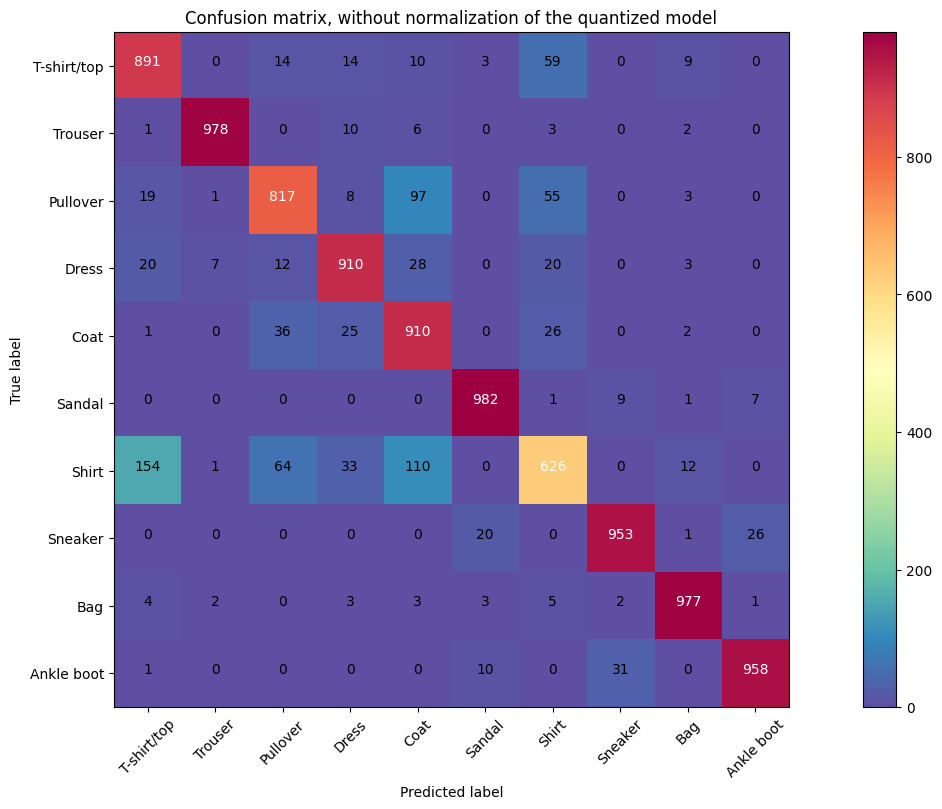

In [23]:
# we plot also the confusion matrix of the quantized model
tflite_model_quant_int8_pred = run_tflite_model(tflite_model_quant_int8_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())

In [24]:
# compute the accuracy of the quantized model
from sklearn.metrics import accuracy_score
full_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_pred)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))
print("Quantized model accuracy is %.4f%% (Number of test samples=%d)" % (full_int8_accuracy * 100, len(test_images)))

Full-precision model accuracy is 90.0600% (Number of test samples=10000)
Quantized model accuracy is 90.0200% (Number of test samples=10000)


### Writing the model to a C header file for use on the MCU
We need to store the model parameters in a C header file so that we can run inference on the microcontroller with new input data (i.e.) from the testset. 

In [25]:
def hex_to_c_array(hex_data, var_name, model_type='uint8'):
    """
    Convert hex data to a C array with support for 8-bit quantized, float, int8, and int32 models.
    
    Parameters:
    - hex_data: List of values to be converted.
    - var_name: Name of the C array variable.
    - model_type: Data type of the model ('uint8', 'int8', 'float', 'int32').
    
    Returns:
    - A string containing the C array representation of the data.
    """
    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Determine data type and formatting based on model type
    if model_type == 'uint8':
        data_type = 'unsigned char'
        format_str = '#04x'  # 2-digit hex with leading '0x'
    elif model_type == 'int8':
        data_type = 'char'
        format_str = '#04x'  # 2-digit hex with leading '0x'
    elif model_type == 'int32':
        data_type = 'int'
        format_str = '#010x'  # 8-digit hex with leading '0x'
    elif model_type == 'float':
        data_type = 'float'
        format_str = '.8e'  # Scientific notation for float
    else:
        raise ValueError("Unsupported model type. Use 'uint8', 'int8', 'int32', or 'float'.")

    # Add array length at top of file
    c_str += '\nstatic const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'static const ' + data_type + ' ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):
        if model_type in ['uint8', 'int8', 'int32']:
            # Construct string from hex
            hex_str = format(val, format_str)
        elif model_type == 'float':
            # Assume `val` is already a float; format accordingly
            hex_str = format(val, format_str)

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str


In [26]:
c_model_name = 'q8fmnist'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8, c_model_name, model_type='uint8'))

### Generating sample image for MCU inference

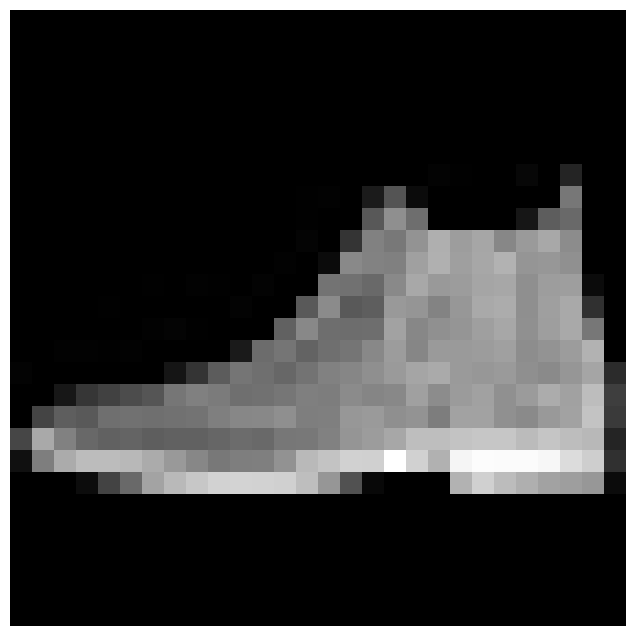

In [36]:
plt.figure()
plt.imshow(test_images[0], cmap='gray')
plt.axis('off')
plt.savefig('test_image.png', bbox_inches='tight')
plt.show()


# Write TFLite model to a C source (or header) file
with open('cfiles/' + 'data.h', 'w') as file:
    file.write(hex_to_c_array(test_images[0].astype(np.uint8).tobytes(), "test_image", model_type='uint8'))

### Saving test data used for inference on the MCU
Additionally, we will save some samples from the test set which we will send via UART to the microcontroller. The microcontroller will then perform inference on these samples and send the results back to the host computer via a Python script that we prepared for you. 

Test image data location:  /home/mgiordano/Documents/arm_workshop/jupyter/x_test_fmnist.npy
Test labels location:  /home/mgiordano/Documents/arm_workshop/jupyter/y_test_fmnist.npy


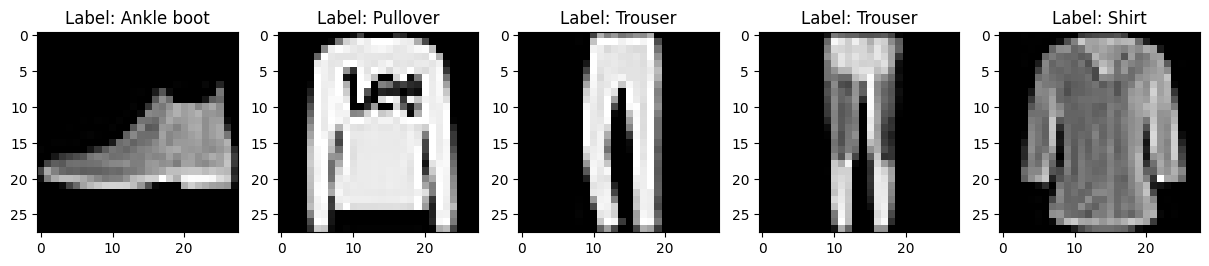

In [27]:
# save the test data as numpy arrays
np.save('x_test_fmnist.npy', test_images_float.astype(np.uint8))
np.save('y_test_fmnist.npy', test_labels.astype(np.uint8))
# plot the first 5 images in the test set with their labels
# map class labels to names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images_float.astype(np.uint8)[i], cmap='gray')
    plt.title('Label: %s' % class_names[test_labels[i]])

# print the location of the files
print('Test image data location: ', os.path.abspath('x_test_fmnist.npy'))
print('Test labels location: ', os.path.abspath('y_test_fmnist.npy'))